Analysis of the evalutation results

In [17]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

results_dir = "../data/local_eval/"
result_files = glob.glob(os.path.join(results_dir, "**/*_results.json"), recursive=True)

all_results = []
for file in result_files:
    with open(file, "r") as f:
        data = json.load(f)
    model_dir = os.path.basename(os.path.dirname(file))
    approach = os.path.basename(file).replace("_results.json", "")
    row = {
        "model": model_dir,
        "approach": approach,
        "accuracy": data.get("accuracy"),
        "chatgpt": data.get("chatgpt"),
        "match": data.get("match"),
    }

    for k, v in data.get("language", {}).items():
        row[k] = v

    all_results.append(row)


df = pd.DataFrame(all_results)

In [18]:
# Table Comparison
language_keys = [
    "val/Bleu_1",
    "val/Bleu_2",
    "val/Bleu_3",
    "val/Bleu_4",
    "val/ROUGE_L",
    "val/CIDEr",
]
score_keys = ["accuracy", "chatgpt", "match"] + language_keys

display_cols = ["model", "approach"] + score_keys
display(df[display_cols])

,model,approach,accuracy,chatgpt,match,val/Bleu_1,val/Bleu_2,val/Bleu_3,val/Bleu_4,val/ROUGE_L,val/CIDEr
0,Qwen_Qwen2.5-VL-3B-Instruct,OpenGVLab_InternVL3-2B_useGrid,1.0,0.0,50.0,9.397644e-13,4.202754e-20,1.491783e-19,2.810551e-19,0.029526,0.0
1,Qwen_Qwen2.5-VL-3B-Instruct,OpenGVLab_InternVL3-2B_useAugmented,1.0,0.0,50.0,9.397644e-13,4.202754e-20,1.491783e-19,2.810551e-19,0.029526,0.0


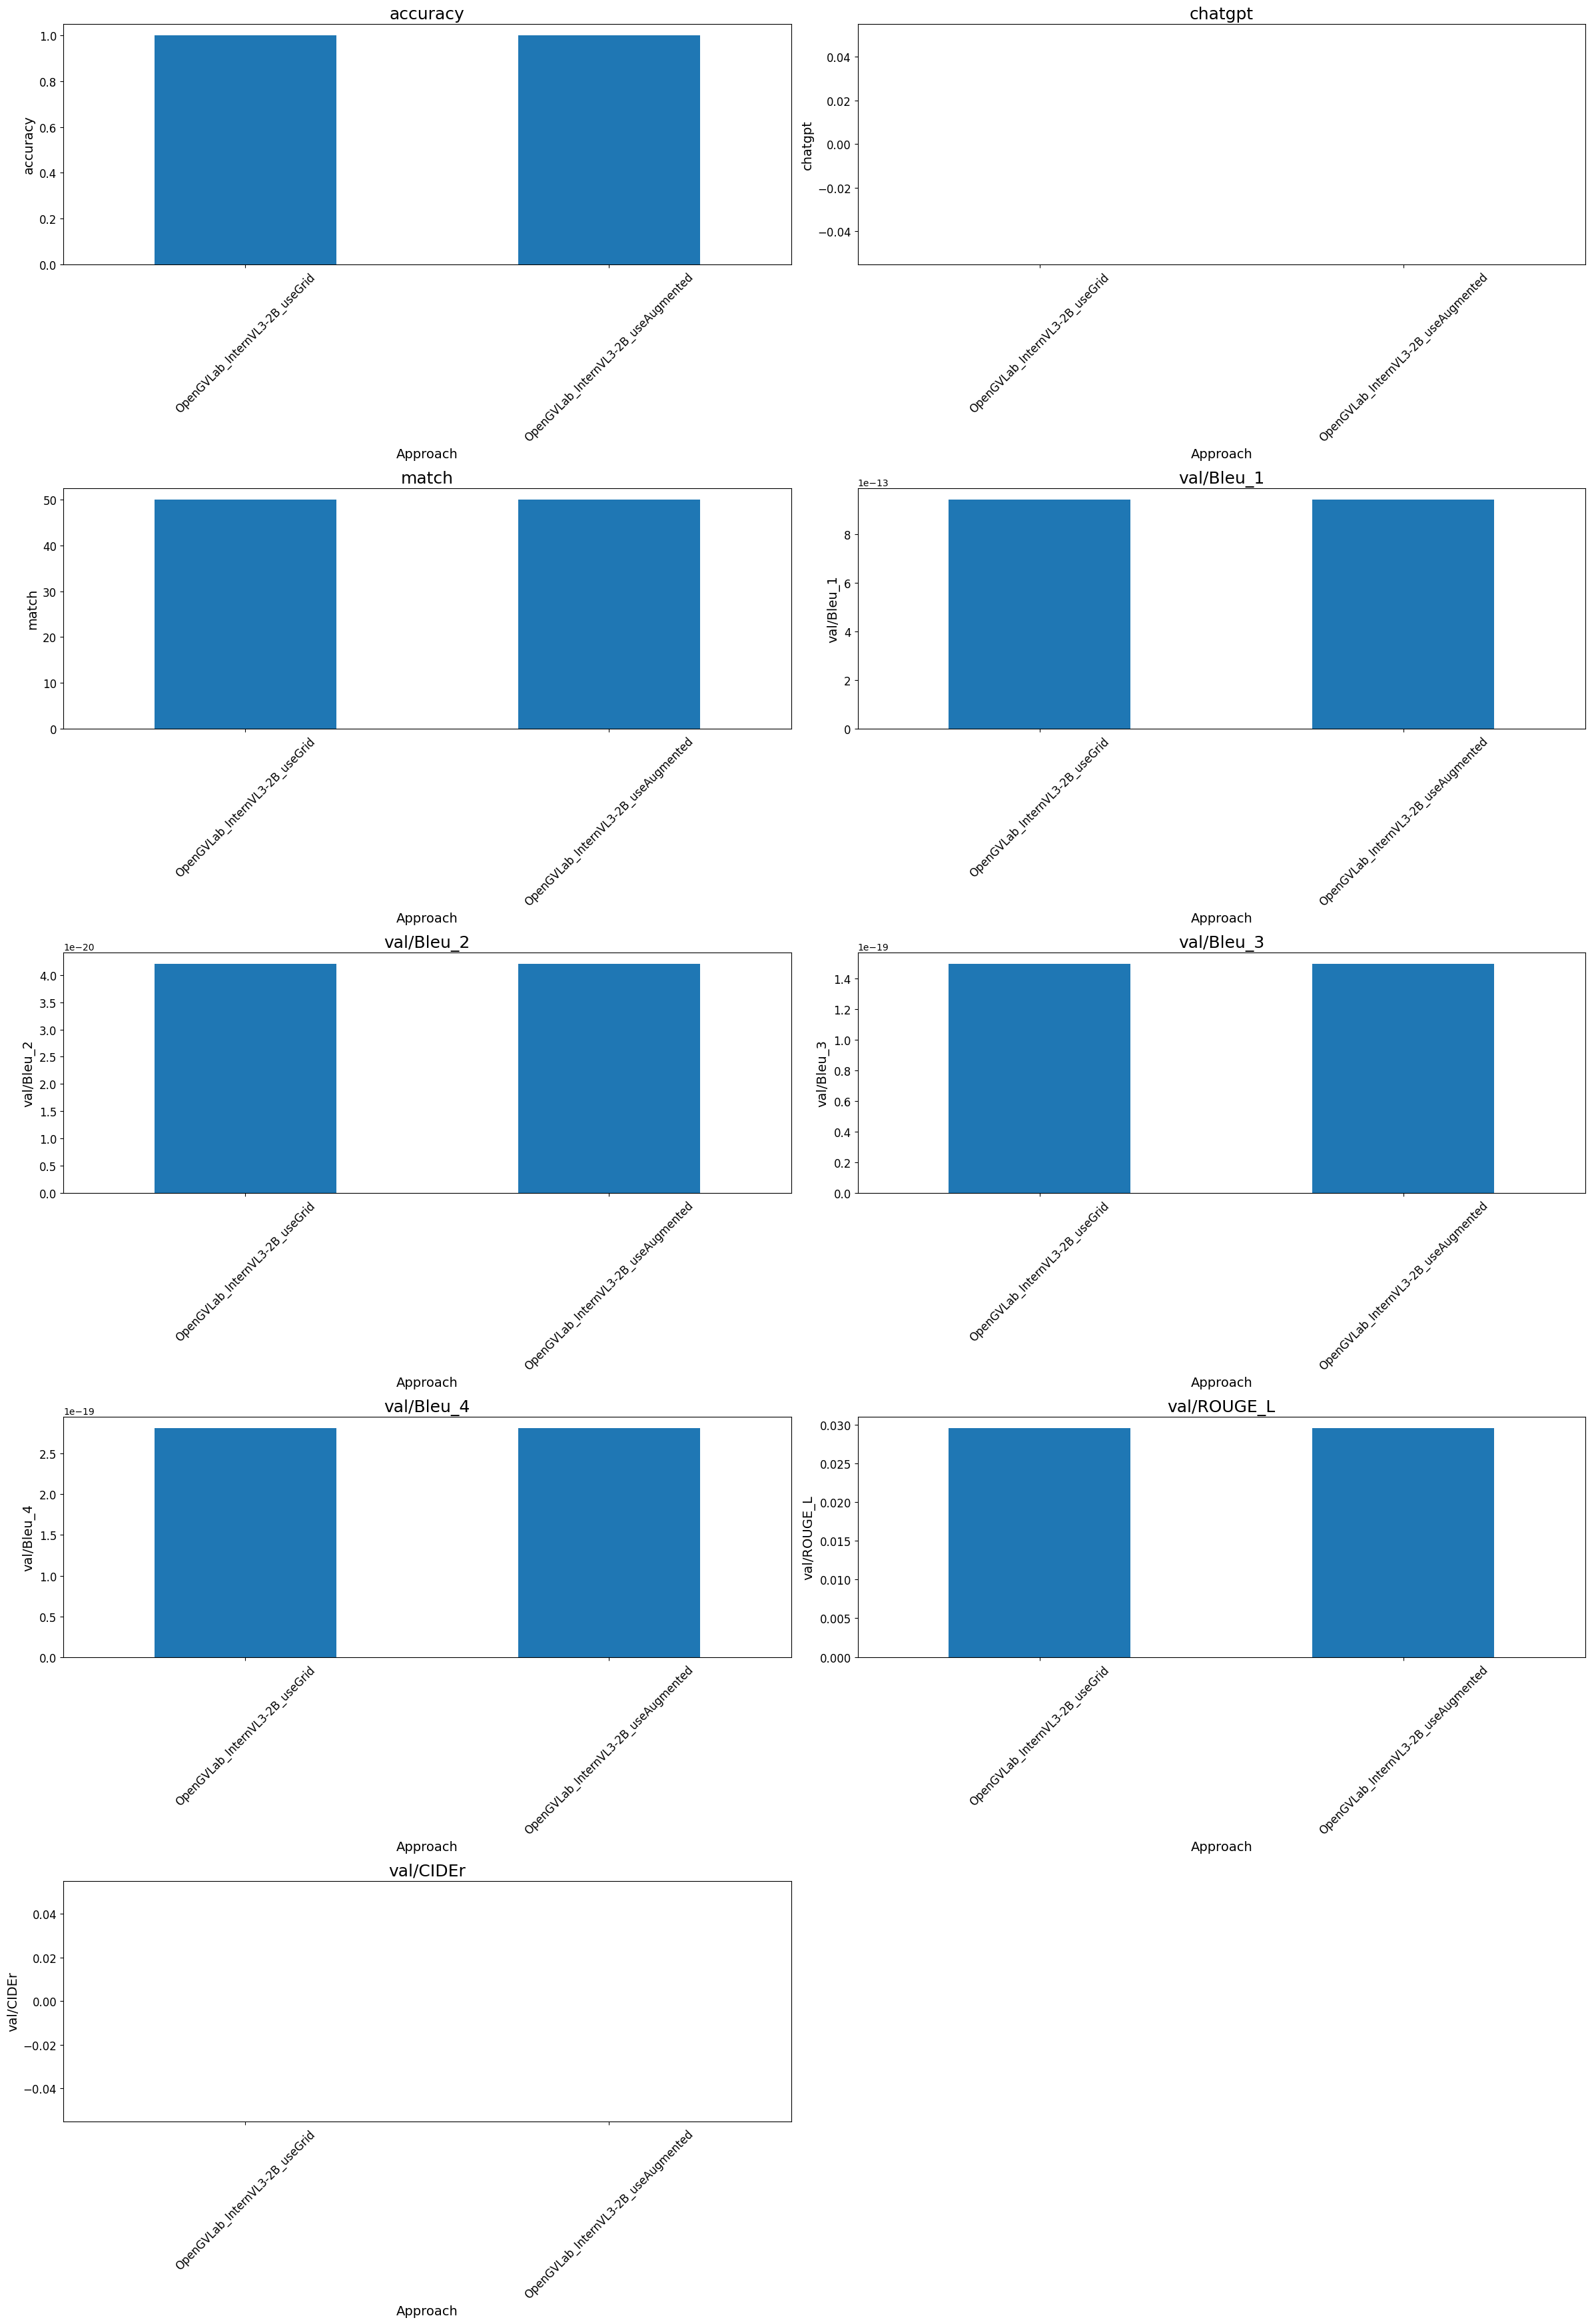

In [21]:
# Bar chats for score
n_cols = 2
n_rows = int(np.ceil(len(score_keys) / n_cols))
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(12 * n_cols, 7 * n_rows), sharey=False
)
axes = axes.flatten()  # Flatten in case of single row

for i, key in enumerate(score_keys):
    df.plot.bar(x="approach", y=key, ax=axes[i], legend=False)
    axes[i].set_title(key, fontsize=18)
    axes[i].set_xlabel("Approach", fontsize=14)
    axes[i].set_ylabel(key, fontsize=14)
    axes[i].tick_params(axis="x", rotation=45, labelsize=12)
    axes[i].tick_params(axis="y", labelsize=12)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
#  Per-Question Analysis

# 10 Best & 10 Worst Questions for Each Score and Approach
per_question_score_keys = [
    "accuracy",
    "match",
    "Bleu_1",
    "Bleu_2",
    "Bleu_3",
    "Bleu_4",
    "ROUGE_L",
    "CIDEr",
]

for idx, row in df.iterrows():
    approach = row["approach"]
    model = row["model"]

    file = [f for f in result_files if os.path.basename(f).startswith(approach)][0]
    with open(file, "r") as f:
        data = json.load(f)
    per_q = data.get("per_question_scores", {})
    print(f"\n=== Model: {model} | Approach: {approach} ===")
    for score in per_question_score_keys:
        q_scores = [
            (qid, v.get(score)) for qid, v in per_q.items() if v.get(score) is not None
        ]
        if not q_scores:
            continue

        q_scores_sorted = sorted(q_scores, key=lambda x: x[1])

        print(f"\nScore: {score}")
        print("10 Worst:")
        display(pd.DataFrame(q_scores_sorted[:10], columns=["question_id", score]))
        print("10 Best:")
        display(pd.DataFrame(q_scores_sorted[-10:], columns=["question_id", score]))

# Mean, standard deviation, median of each score by approach
std_median_rows = []
for idx, row in df.iterrows():
    approach = row["approach"]
    model = row["model"]
    file = [f for f in result_files if os.path.basename(f).startswith(approach)][0]
    with open(file, "r") as f:
        data = json.load(f)
    per_q = data.get("per_question_scores", {})
    stats = {"model": model, "approach": approach}
    for score in per_question_score_keys:
        vals = [v.get(score) for v in per_q.values() if v.get(score) is not None]
        if vals:
            stats[f"{score}_mean"] = np.mean(vals)
            stats[f"{score}_std"] = np.std(vals)
            stats[f"{score}_median"] = np.median(vals)
        else:
            stats[f"{score}_mean"] = np.nan
            stats[f"{score}_std"] = np.nan
            stats[f"{score}_median"] = np.nan
    std_median_rows.append(stats)

std_median_df = pd.DataFrame(std_median_rows)
print("Standard deviation and median")
display(std_median_df)


=== Model: Qwen_Qwen2.5-VL-3B-Instruct | Approach: OpenGVLab_InternVL3-2B_useGrid ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.0


10 Best:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.0



Score: match
10 Worst:


,question_id,match
0,fd4ef697de684d0a8e016a8f8ae61193_6fc0149b2f914...,99.999999


10 Best:


,question_id,match
0,fd4ef697de684d0a8e016a8f8ae61193_6fc0149b2f914...,99.999999



Score: Bleu_1
10 Worst:


,question_id,Bleu_1
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,9.397644e-13
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00


10 Best:


,question_id,Bleu_1
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,9.397644e-13
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00



Score: Bleu_2
10 Worst:


,question_id,Bleu_2
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,4.202754e-20
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00


10 Best:


,question_id,Bleu_2
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,4.202754e-20
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00



Score: Bleu_3
10 Worst:


,question_id,Bleu_3
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,1.491783e-19
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00


10 Best:


,question_id,Bleu_3
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,1.491783e-19
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00



Score: Bleu_4
10 Worst:


,question_id,Bleu_4
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,2.810551e-19
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00


10 Best:


,question_id,Bleu_4
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,2.810551e-19
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00



Score: ROUGE_L
10 Worst:


,question_id,ROUGE_L
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.029526
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000


10 Best:


,question_id,ROUGE_L
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.029526
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000



Score: CIDEr
10 Worst:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0


10 Best:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct | Approach: OpenGVLab_InternVL3-2B_useAugmented ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.0


10 Best:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.0



Score: match
10 Worst:


,question_id,match
0,fd4ef697de684d0a8e016a8f8ae61193_6fc0149b2f914...,99.999999


10 Best:


,question_id,match
0,fd4ef697de684d0a8e016a8f8ae61193_6fc0149b2f914...,99.999999



Score: Bleu_1
10 Worst:


,question_id,Bleu_1
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,9.397644e-13
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00


10 Best:


,question_id,Bleu_1
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,9.397644e-13
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00



Score: Bleu_2
10 Worst:


,question_id,Bleu_2
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,4.202754e-20
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00


10 Best:


,question_id,Bleu_2
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,4.202754e-20
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00



Score: Bleu_3
10 Worst:


,question_id,Bleu_3
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,1.491783e-19
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00


10 Best:


,question_id,Bleu_3
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,1.491783e-19
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00



Score: Bleu_4
10 Worst:


,question_id,Bleu_4
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,2.810551e-19
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00


10 Best:


,question_id,Bleu_4
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,2.810551e-19
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000e+00



Score: ROUGE_L
10 Worst:


,question_id,ROUGE_L
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.029526
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000


10 Best:


,question_id,ROUGE_L
0,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.029526
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,1.000000



Score: CIDEr
10 Worst:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0


10 Best:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0


Standard deviation and median


,model,approach,accuracy_std,accuracy_median,match_std,match_median,Bleu_1_std,Bleu_1_median,Bleu_2_std,Bleu_2_median,Bleu_3_std,Bleu_3_median,Bleu_4_std,Bleu_4_median,ROUGE_L_std,ROUGE_L_median,CIDEr_std,CIDEr_median
0,Qwen_Qwen2.5-VL-3B-Instruct,OpenGVLab_InternVL3-2B_useGrid,0.0,1.0,0.0,99.999999,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.485237,0.514763,0.0,0.0
1,Qwen_Qwen2.5-VL-3B-Instruct,OpenGVLab_InternVL3-2B_useAugmented,0.0,1.0,0.0,99.999999,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.485237,0.514763,0.0,0.0
